# Panoramic Stitching

Kevin Walchko, created 10 Dec 2016

--------

**there is an error in OpenCV python i am waiting on being fixed**

[error](https://github.com/opencv/opencv/pull/7787)

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import cv2
from math import sqrt
import opencvutils as cvu

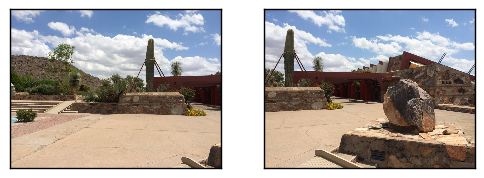

In [14]:
images = [
    'stitch_pics/scottsdale_left_01.png',
    'stitch_pics/scottsdale_right_01.png'
]
imgs = []
for fname in images:
    image = cv2.imread(fname)
    imgs.append(image)

cvu.imshow(imgs)

In [4]:
stitcher = cv2.createStitcher(False)
ans = stitcher.stitch(imgs)
# ans = stitcher.stitch((imgs[0],imgs[1]))

error: /tmp/opencv3-20161211-55427-1q3z61z/modules/python/src2/cv2.cpp:152: error: (-215) The data should normally be NULL! in function allocate


In [5]:
class Stitcher:
    def __init__(self):
        # determine if we are using OpenCV v3.X
        self.isv3 = cvu.is_cv3()

    def stitch(self, images, ratio=0.75, reprojThresh=4.0, showMatches=False):
        # unpack the images, then detect keypoints and extract
        # local invariant descriptors from them
        (imageB, imageA) = images
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)

        # match features between the two images
        M = self.matchKeypoints(kpsA, kpsB,
            featuresA, featuresB, ratio, reprojThresh)

        # if the match is None, then there aren't enough matched
        # keypoints to create a panorama
        if M is None:
            return None

        # otherwise, apply a perspective warp to stitch the images
        # together
        (matches, H, status) = M
        result = cv2.warpPerspective(imageA, H,
            (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

        # check to see if the keypoint matches should be visualized
        if showMatches:
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches,
                status)

            # return a tuple of the stitched image and the
            # visualization
            return (result, vis)

        # return the stitched image
        return result

    def detectAndDescribe(self, image):
        # convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # check to see if we are using OpenCV 3.X
        if self.isv3:
            # detect and extract features from the image
            descriptor = cv2.xfeatures2d.SIFT_create()
            (kps, features) = descriptor.detectAndCompute(image, None)

        # otherwise, we are using OpenCV 2.4.X
        else:
            # detect keypoints in the image
            detector = cv2.FeatureDetector_create("SIFT")
            kps = detector.detect(gray)

            # extract features from the image
            extractor = cv2.DescriptorExtractor_create("SIFT")
            (kps, features) = extractor.compute(gray, kps)

        # convert the keypoints from KeyPoint objects to NumPy
        # arrays
        kps = np.float32([kp.pt for kp in kps])

        # return a tuple of keypoints and features
        return (kps, features)

    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        # compute the raw matches and initialize the list of actual
        # matches
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []

        # loop over the raw matches
        for m in rawMatches:
            # ensure the distance is within a certain ratio of each
            # other (i.e. Lowe's ratio test)
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # computing a homography requires at least 4 matches
        if len(matches) > 4:
            # construct the two sets of points
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # compute the homography between the two sets of points
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
                reprojThresh)

            # return the matches along with the homograpy matrix
            # and status of each matched point
            return (matches, H, status)

        # otherwise, no homograpy could be computed
        return None

    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        # initialize the output visualization image
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        # loop over the matches
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # only process the match if the keypoint was successfully
            # matched
            if s == 1:
                # draw the match
                ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

        # return the visualization
        return vis

In [5]:
descriptor = cv2.ORB_create()

In [12]:
gray = cv2.cvtColor(imgs[1], cv2.COLOR_BGR2GRAY)
mask = np.zeros((750,1000), np.uint8)
mask = np.zeros((70,10), np.uint8)
descriptor = cv2.ORB_create()
kps, features = descriptor.detectAndCompute(gray,None)

In [13]:
kps

[<KeyPoint 0x119866ab0>,
 <KeyPoint 0x119866bd0>,
 <KeyPoint 0x119866b70>,
 <KeyPoint 0x119866ba0>,
 <KeyPoint 0x119866b40>,
 <KeyPoint 0x119866ae0>,
 <KeyPoint 0x119866c30>,
 <KeyPoint 0x119866c90>,
 <KeyPoint 0x119866cc0>,
 <KeyPoint 0x119866cf0>,
 <KeyPoint 0x119866d20>,
 <KeyPoint 0x119866d50>,
 <KeyPoint 0x119866d80>,
 <KeyPoint 0x119866db0>,
 <KeyPoint 0x119866de0>,
 <KeyPoint 0x119866e10>,
 <KeyPoint 0x119866e40>,
 <KeyPoint 0x119866e70>,
 <KeyPoint 0x119866ea0>,
 <KeyPoint 0x119866ed0>,
 <KeyPoint 0x119866f00>,
 <KeyPoint 0x119866f30>,
 <KeyPoint 0x119866f60>,
 <KeyPoint 0x119866f90>,
 <KeyPoint 0x119866fc0>,
 <KeyPoint 0x118f78030>,
 <KeyPoint 0x118f78060>,
 <KeyPoint 0x118f78090>,
 <KeyPoint 0x118f780c0>,
 <KeyPoint 0x118f780f0>,
 <KeyPoint 0x118f78120>,
 <KeyPoint 0x118f78150>,
 <KeyPoint 0x118f78180>,
 <KeyPoint 0x118f781b0>,
 <KeyPoint 0x118f781e0>,
 <KeyPoint 0x118f78210>,
 <KeyPoint 0x118f78240>,
 <KeyPoint 0x118f78270>,
 <KeyPoint 0x118f782a0>,
 <KeyPoint 0x118f782d0>,


In [41]:
class Stitcher2:
    def __init__(self):
        # determine if we are using OpenCV v3.X
        self.isv3 = cvu.is_cv3()

    def stitch(self, images, ratio=0.75, reprojThresh=4.0, showMatches=False):
        # unpack the images, then detect keypoints and extract
        # local invariant descriptors from them
#         (imageB, imageA) = images
#         (kpsA, featuresA) = self.detectAndDescribe(imageA)
#         (kpsB, featuresB) = self.detectAndDescribe(imageB)
        
        kps = []
        features = []
        mm = []
        
        for im in images:
            (k, f) = self.detectAndDescribe(im)
            kps.append(k)
            features.append(f)

        for i in range(len(kps)-1):
            # match features between the two images
            imageA = images[i]
            imageB = images[i+1]
            kpsA = kps[i]
            kpsB = kps[i+1]
            featureA = features[i]
            featureB = features[i+1]
            M = self.matchKeypoints(kpsA, kpsB,
                featuresA, featuresB, ratio, reprojThresh)

            # if the match is None, then there aren't enough matched
            # keypoints to create a panorama
            if M is None:
                continue
            else:
#                 m.append(M)
#                 return None

                # otherwise, apply a perspective warp to stitch the images
                # together
                (matches, H, status) = M
                result = cv2.warpPerspective(imageA, H,
                    (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
                result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

        # check to see if the keypoint matches should be visualized
#         if showMatches:
#             vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches,
#                 status)

#             # return a tuple of the stitched image and the
#             # visualization
#             return (result, vis)

        # return the stitched image
        return result

    def detectAndDescribe(self, image):
        # convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # check to see if we are using OpenCV 3.X
#         if self.isv3:
        # detect and extract features from the image
        descriptor = cv2.xfeatures2d.SIFT_create()
        (kps, features) = descriptor.detectAndCompute(image, None)

        # otherwise, we are using OpenCV 2.4.X
#         else:
#             # detect keypoints in the image
#             detector = cv2.FeatureDetector_create("SIFT")
#             kps = detector.detect(gray)

#             # extract features from the image
#             extractor = cv2.DescriptorExtractor_create("SIFT")
#             (kps, features) = extractor.compute(gray, kps)

        # convert the keypoints from KeyPoint objects to NumPy
        # arrays
        kps = np.float32([kp.pt for kp in kps])

        # return a tuple of keypoints and features
        return (kps, features)

    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        # compute the raw matches and initialize the list of actual
        # matches
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []

        # loop over the raw matches
        for m in rawMatches:
            # ensure the distance is within a certain ratio of each
            # other (i.e. Lowe's ratio test)
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # computing a homography requires at least 4 matches
        if len(matches) > 4:
            # construct the two sets of points
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # compute the homography between the two sets of points
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
                reprojThresh)

            # return the matches along with the homograpy matrix
            # and status of each matched point
            return (matches, H, status)

        # otherwise, no homograpy could be computed
        return None

#     def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
#         # initialize the output visualization image
#         (hA, wA) = imageA.shape[:2]
#         (hB, wB) = imageB.shape[:2]
#         vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
#         vis[0:hA, 0:wA] = imageA
#         vis[0:hB, wA:] = imageB

#         # loop over the matches
#         for ((trainIdx, queryIdx), s) in zip(matches, status):
#             # only process the match if the keypoint was successfully
#             # matched
#             if s == 1:
#                 # draw the match
#                 ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
#                 ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
#                 cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

#         # return the visualization
#         return vis

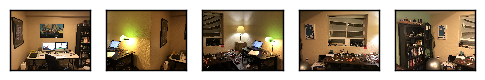

In [35]:
fname = [
    'stitch_pics/IMG_1508.JPG',
    'stitch_pics/IMG_1509.JPG',
    'stitch_pics/IMG_1510.JPG',
    'stitch_pics/IMG_1511.JPG',
    'stitch_pics/IMG_1512.JPG',
#     'stitch_pics/IMG_1513.JPG'
#     'stitch_pics/IMG_1514.JPG',
#     'stitch_pics/IMG_1515.JPG',
#     'stitch_pics/IMG_1516.JPG',
#     'stitch_pics/IMG_1517.JPG',
#     'stitch_pics/IMG_1518.JPG',
#     'stitch_pics/IMG_1519.JPG'
]
imgs2 = []
for f in fname:
    image = cv2.imread(f)
    imgs2.append(image)

# plt.imshow(imgs[0], cmap=plt.cm.gray);
cvu.imshow(imgs2, width=5)

In [43]:
stitcher = Stitcher2()
# (result, vis) = stitcher.stitch(imgs, showMatches=True)
result = stitcher.stitch(imgs, showMatches=False)

NameError: global name 'featuresA' is not defined

In [37]:
stitcher = Stitcher()
ans = cvu.resize(imgs2[4], width=640)
for im in reversed(imgs2[:3]):
    im = cvu.resize(im, width=640)
    ans = stitcher.stitch([ans, im])
plt.imshow(ans)

error: /tmp/opencv3-20161211-55427-1q3z61z/modules/imgproc/src/color.cpp:9748: error: (-215) scn == 3 || scn == 4 in function cvtColor


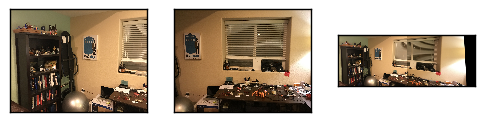

In [38]:
stitcher = Stitcher()
a = cvu.resize(imgs2[4], width=640)
b = cvu.resize(imgs2[3], width=640)
ans = stitcher.stitch([a,b])
cvu.imshow([imgs2[4], imgs2[3], ans])

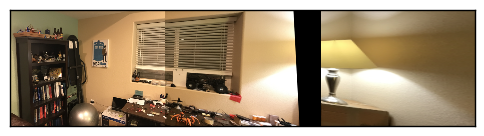

In [39]:
b = cvu.resize(imgs2[2], width=640)
ans = stitcher.stitch([ans,b])
cvu.imshow([ans])

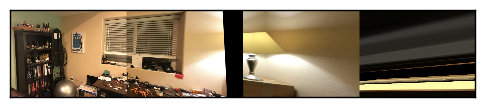

In [40]:
b = cvu.resize(imgs2[1], width=640)
ans = stitcher.stitch([ans,b])
cvu.imshow([ans])

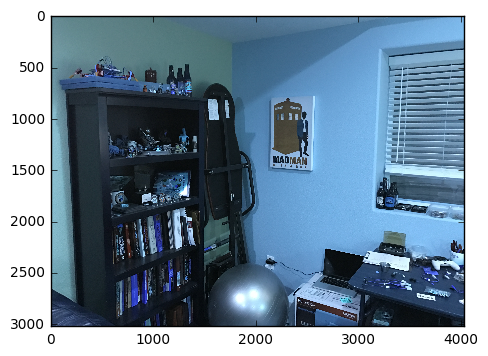

In [34]:
plt.imshow(imgs2[4])